In [1]:
# Requirements
# Comment if already satisfied
#!pip install -U jupyter
#!pip install datasets transformers accelerate torch torchinfo xlrd
#!pip install --upgrade --quiet jupyter_client ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import pandas as pd

DATA_DIR = "../data/"
OUT_DIR = "./out/language_model"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

# Utility Function

In [3]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, out_dir):
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(f"Language Model Fine-Tune History")
    ax.set_title("Perplexity")
    ax.plot(train_history["perplexity"], label="train")
    ax.plot(val_history["perplexity"], label="val")
    ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/language_model_history.png", dpi=150, bbox_inches='tight')

    return fig

# Load Dataset

In [4]:
#articles = pd.read_excel(os.path.join(DATA_DIR, "OpArticles.xlsx"))
articles = pd.read_csv(os.path.join(DATA_DIR, "OpArticles.csv")) # If pandas version doesn't support .xlsx, use this instaed

articles.head()

,article_id,title,authors,body,meta_description,topics,keywords,publish_date,url_canonical
0,5d04a31b896a7fea069ef06f,"Pouco pão e muito circo, morte e bocejo",['José Vítor Malheiros'],"O poeta espanhol António Machado escrevia, uns...","É tudo cómico na FIFA, porque todos os dias a ...",Sports,"['Brasil', 'Campeonato do Mundo', 'Desporto', ...",2014-06-17 00:16:00,https://www.publico.pt/2014/06/17/desporto/opi...
1,5d04a3fc896a7fea069f0717,Portugal nos Mundiais de Futebol de 2010 e 2014,['Rui J. Baptista'],“O mais excelente quadro posto a uma luz logo ...,Deve ser evidenciado o clima favorável criado ...,Sports,"['Brasil', 'Campeonato do Mundo', 'Coreia do N...",2014-07-05 02:46:00,https://www.publico.pt/2014/07/05/desporto/opi...
2,5d04a455896a7fea069f07ab,"Futebol, guerra, religião",['Fernando Belo'],1. As sociedades humanas parecem ser regidas p...,O futebol parece ser um sucedâneo quer da lei ...,Sports,"['A guerra na Síria', 'Desporto', 'Futebol', '...",2014-07-12 16:05:33,https://www.publico.pt/2014/07/12/desporto/opi...
3,5d04a52f896a7fea069f0921,As razões do Qatar para acolher o Mundial em 2022,['Hamad bin Khalifa bin Ahmad Al Thani'],Este foi um Mundial incrível. Vimos actuações ...,Queremos cooperar plenamente com a investigaçã...,Sports,"['Desporto', 'FIFA', 'Futebol', 'Mundial de fu...",2014-07-27 02:00:00,https://www.publico.pt/2014/07/27/desporto/opi...
4,5d04a8d7896a7fea069f6997,A política no campo de futebol,['Carlos Nolasco'],O futebol sempre foi um jogo aparentemente sim...,Retirar a expressão política do futebol é reti...,Sports,"['Albânia', 'Campeonato da Europa', 'Desporto'...",2014-10-23 00:16:00,https://www.publico.pt/2014/10/23/desporto/opi...


# Convert Dataset to HF Dataset

In [5]:
from datasets import Dataset

articles_dataset = Dataset.from_pandas(articles)

print(articles_dataset)

Dataset({
    features: ['article_id', 'title', 'authors', 'body', 'meta_description', 'topics', 'keywords', 'publish_date', 'url_canonical'],
    num_rows: 373
})


Remove unnecessary columns

In [6]:
articles_dataset = articles_dataset.remove_columns(["authors", "publish_date", "url_canonical"])
print(articles_dataset)

Dataset({
    features: ['article_id', 'title', 'body', 'meta_description', 'topics', 'keywords'],
    num_rows: 373
})


# Base Tokenizer

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)

In [8]:
def tokenize(batch):
    result = tokenizer(batch["body"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

In [9]:
tokenized_dataset = articles_dataset.map(
    tokenize, batched=True, remove_columns=["article_id", "title", "body", "meta_description", "topics", "keywords"]
)

print(tokenized_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 373
})


# Transform dataset to chunks

In [10]:
CHUNK_SIZE = 128

def chunk_dataset(batch):
    concatenated_batch = { k: sum(batch[k], []) for k in batch.keys() }

    total_length = len(concatenated_batch[list(batch.keys())[0]])
    total_length = (total_length // CHUNK_SIZE) * CHUNK_SIZE

    result = {
        k: [v[i : i + CHUNK_SIZE] for i in range(0, total_length, CHUNK_SIZE)]
            for k, v in concatenated_batch.items()
    }
    result["labels"] = result["input_ids"].copy() # Needed for masked LM training
    return result

chunked_dataset = tokenized_dataset.map(
    chunk_dataset, batched=True
)

print(chunked_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 3643
})


# Create a validation split

In [11]:
lm_dataset = chunked_dataset.train_test_split(train_size=0.8, seed=42)
print(lm_dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 2914
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 729
    })
})


# Mask tokens for training

In [12]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.2
)

def insert_random_mask(batch):
    features = [ dict(zip(batch, v)) for v in zip(*batch.values()) ]
    masked_inputs = data_collator(features)

    return { f"masked_{k}": v.numpy() for k, v in masked_inputs.items() }

lm_dataset = lm_dataset.remove_columns(["word_ids"])

val_dataset = lm_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=lm_dataset["test"].column_names,
)

val_dataset = val_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
        "masked_token_type_ids": "token_type_ids"
    }
)

lm_dataset["test"] = val_dataset

print(lm_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2914
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 729
    })
})


# Define Dataloaders

In [13]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

BATCH_SIZE = 16 # Tested with NVIDIA Tesla T4 16GB | Can't run on GPU on NVIDIA 1050TI 4GB, even with BATCH_SIZE=1
train_dataloader = DataLoader(
    dataset=lm_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=lm_dataset["test"],
    batch_size=BATCH_SIZE,
    collate_fn=default_data_collator
)

# Model Definition

In [14]:
from transformers import AutoModelForMaskedLM
from torchinfo import summary

model = AutoModelForMaskedLM.from_pretrained('neuralmind/bert-large-portuguese-cased')

summary(model)

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
BertForMaskedLM                                         --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
├─BertOnlyMLMHead: 1-2                                  --
│    └─BertLMPredictionHead: 2-3                        --
│    │    └─BertPredictionHeadTransform: 3-7            1,051,648
│    │    └─Linear: 3-8                                 30,538,850
Total params: 364,937,314
Trainable params: 364,937,314
Non-trainab

# Define Optimizer


In [15]:
from torch import optim

optimizer = optim.AdamW(
    params=model.parameters(),
    lr=1e-5,
    betas=(0.9, 0.999),
    weight_decay=1e-4,
    amsgrad=True
)

# Prepare Language Model

In [16]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


# Define Epoch Iteration

In [17]:
import torch
from tqdm import tqdm
import numpy as np

def epoch_iter(dataloader, model, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."

    if is_train:
        model.train()
    else:
        model.eval()

    losses = []

    with torch.set_grad_enabled(is_train):
        for batch in tqdm(dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            if is_train:
                optimizer.zero_grad()
                accelerator.backward(loss)
                optimizer.step()
            
            losses.append(loss.item())
    
        if is_train and lr_scheduler is not None:
            lr_scheduler.step()

    try:
        mean_loss = np.mean(losses)
        perplexity = np.exp(mean_loss)
    except:
        mean_loss = np.inf
        perplexity = np.inf

    return perplexity, mean_loss

# Train Language Model

In [18]:
!nvidia-smi

Sat Jun  4 17:16:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P0    26W /  70W |   2404MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [19]:
from transformers import get_scheduler

NUM_EPOCHS = 10

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS,
)

In [20]:
train_history = {
    "loss": [],
    "perplexity": []
}

val_history = {
    "loss": [],
    "perplexity": []
}

best_perplexity = np.inf
best_epoch = -1

print(f"Starting masked language model training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")

    train_perplexity, train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )

    print(f"Training loss: {train_loss:.3f}\t Training perplexity: {train_perplexity:.3f}")

    val_perplexity, val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    print(f"Validation loss: {val_loss:.3f}\t Validation perplexity: {val_perplexity:.3f}")

    if val_perplexity < best_perplexity:
        best_perplexity = val_perplexity
        best_epoch = epoch

        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/latest", save_function=accelerator.save)

    train_history["loss"].append(train_loss)
    train_history["perplexity"].append(train_perplexity)

    val_history["loss"].append(val_loss)
    val_history["perplexity"].append(val_perplexity)

    print("----------------------------------------------------------------")

print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation perplexity on best epoch: {best_perplexity}"
)

Starting masked language model training...
Epoch[1/10]


100%|██████████| 183/183 [04:20<00:00,  1.42s/it]


Training loss: 2.245	 Training perplexity: 9.438


100%|██████████| 46/46 [00:23<00:00,  1.97it/s]


Validation loss: 1.903	 Validation perplexity: 6.708
----------------------------------------------------------------
Epoch[2/10]


100%|██████████| 183/183 [04:13<00:00,  1.38s/it]


Training loss: 1.987	 Training perplexity: 7.296


100%|██████████| 46/46 [00:20<00:00,  2.20it/s]


Validation loss: 1.794	 Validation perplexity: 6.016
----------------------------------------------------------------
Epoch[3/10]


100%|██████████| 183/183 [04:20<00:00,  1.42s/it]


Training loss: 1.924	 Training perplexity: 6.848


100%|██████████| 46/46 [00:20<00:00,  2.28it/s]


Validation loss: 1.774	 Validation perplexity: 5.892
----------------------------------------------------------------
Epoch[4/10]


100%|██████████| 183/183 [04:28<00:00,  1.47s/it]


Training loss: 1.857	 Training perplexity: 6.405


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


Validation loss: 1.738	 Validation perplexity: 5.684
----------------------------------------------------------------
Epoch[5/10]


100%|██████████| 183/183 [04:41<00:00,  1.54s/it]


Training loss: 1.819	 Training perplexity: 6.168


100%|██████████| 46/46 [00:22<00:00,  2.00it/s]


Validation loss: 1.719	 Validation perplexity: 5.576
----------------------------------------------------------------
Epoch[6/10]


100%|██████████| 183/183 [04:39<00:00,  1.53s/it]


Training loss: 1.797	 Training perplexity: 6.030


100%|██████████| 46/46 [00:22<00:00,  2.01it/s]


Validation loss: 1.702	 Validation perplexity: 5.482
----------------------------------------------------------------
Epoch[7/10]


100%|██████████| 183/183 [04:40<00:00,  1.53s/it]


Training loss: 1.761	 Training perplexity: 5.819


100%|██████████| 46/46 [00:23<00:00,  2.00it/s]


Validation loss: 1.691	 Validation perplexity: 5.426
----------------------------------------------------------------
Epoch[8/10]


100%|██████████| 183/183 [04:40<00:00,  1.53s/it]


Training loss: 1.735	 Training perplexity: 5.671


100%|██████████| 46/46 [00:22<00:00,  2.03it/s]


Validation loss: 1.676	 Validation perplexity: 5.346
----------------------------------------------------------------
Epoch[9/10]


100%|██████████| 183/183 [04:29<00:00,  1.47s/it]


Training loss: 1.715	 Training perplexity: 5.558


100%|██████████| 46/46 [00:19<00:00,  2.33it/s]


Validation loss: 1.668	 Validation perplexity: 5.301
----------------------------------------------------------------
Epoch[10/10]


100%|██████████| 183/183 [04:07<00:00,  1.35s/it]


Training loss: 1.689	 Training perplexity: 5.412


100%|██████████| 46/46 [00:20<00:00,  2.21it/s]


Validation loss: 1.660	 Validation perplexity: 5.257
----------------------------------------------------------------

Finished training...
Best epoch: 10	 Validation perplexity on best epoch: 5.257220313492535


# Plotting history

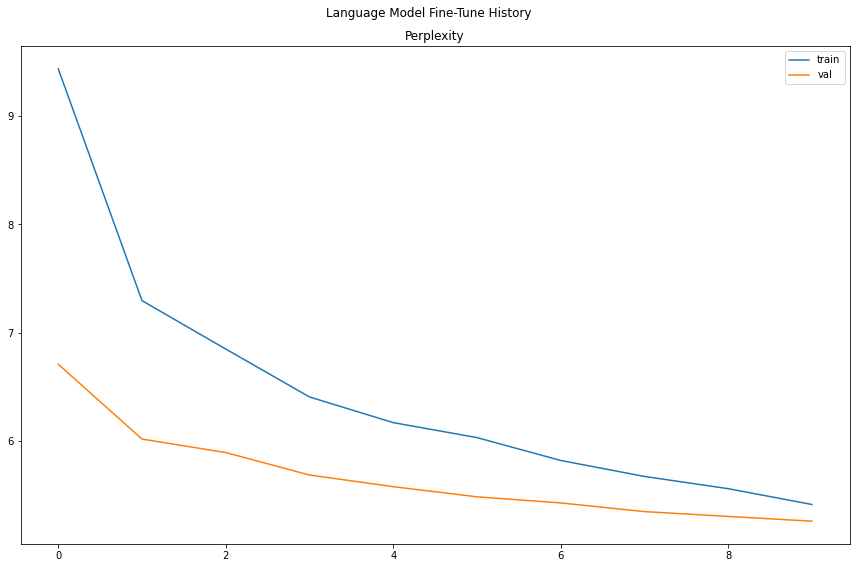

In [21]:
fig = plot_training_history(train_history, val_history, OUT_DIR)

fig.show()